In [3]:
import numpy as np
import matplotlib.pyplot as plt
import gym
import gym_minigrid  # Ajoute les minigrid dans le gym.make
from gym_minigrid.wrappers import ReseedWrapper
from gym_minigrid.envs import EmptyEnv, LavaGapEnv, CrossingEnv, FourRoomsEnv, DistShiftEnv
from helper.tabularminigrid import TabularMiniGrid, WrongActionWrapper
from helper.display import display_env, EnvVideoRecorder

# from mdpql_correction import test_exo1

# Créer un algorithme de Q-Learning

Créez un environnement minigrid EmptyEnv et un wrapper Tabular pour avoir des observations sous forme de coordonnées de la position de l’agent

In [4]:
env = TabularMiniGrid(EmptyEnv(6))

La fonction `display_env` permet d’afficher l’environnement actuel

<AxesSubplot:>

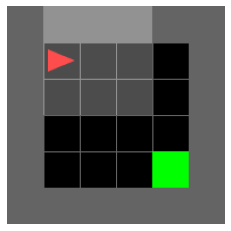

In [5]:
display_env(env)

L’objet EnvVideoRecorder enregistre l’environnement à chaque appel de `add_record`

In [6]:
recorder = EnvVideoRecorder()
env.reset()
for i in range(100):
    action = np.random.choice(len(env.actions))
    recorder.add_record(env)
    obs, reward, done, info = env.step(action)
    if done:
        env.reset()
        recorder.add_record(env)


La fonction `show_anim` permet d’afficher le déroulé de l’environnement enregistré

In [9]:
recorder.show_anim()

Il est aussi possible d’enregistrer la sortie en vidéo avec `recorder.save_mp4("dossier/video.mp4")`

# TP

Les informations de l’environnement sont les suivantes:
- Largeur de l’environnement : `env.width`
- Hauteur de l’environnement : `env.height`
- Actions de l’environnement : `env.actions`
- Nombre d’actions dans l’environnement : `len(env.actions)`
- enfin, les actions sont : `env.actions.right = 0`, `env.actions.down = 1`, `env.actions.left = 2`, `env.actions.up = 3`

Lors d’un reset, l’environnement nous retourne uniquement l’état de l’agent (sa position en (x, y))

```python
>>> obs = env.reset()
np.array([1 1])
```

Lors d’un step, l’environnement nous retourne 4 éléments : le nouvel état de l’agent, la récompense obtenu, si la tâche est fini ou non, et des infos libres (pas utilisées ici)

```python
>>> obs, reward, done, info = env.step(env.action.down)
>>> obs
np.array([1 2])
>>> reward
0
>>> done
False
```

## Exercice 1:

Créez un agent qui soit capable de résoudre l’environnement quelque soit sa taille, pour cela, codez la fonction `supersolver(env, obs)` qui retourne l’action a effectué en lisant les informations de l’observation et de l’environnement.

Notez que l’agent apparait toujours en position (1, 1) et que l’arrivée est toujours en bas à droite. Enfin, l’arène est entourée de mur, donc les cases des bords ne sont pas accessibles.

L’agent dispose de 100 pas de temps pour trouver la solution. Il en aura toujours besoin de moins avec une solution optimale.

In [12]:
def supersolver(env, obs):
    action = env.actions.up
    ### À compléter ici
    if obs[0] < env.width - 2:
        action = env.actions.right
    elif obs[1] < env.height - 2:
        action = env.actions.down

    ### Fin compléter ici
    return action

In [13]:
# Testeur de solution 1
env = TabularMiniGrid(EmptyEnv(6))
recorder = EnvVideoRecorder()
obs = env.reset()
recorder.add_record(env)
for i in range(100):
    action = supersolver(env, obs)
    obs, reward, done, info = env.step(action)
    recorder.add_record(env)
    if done:
        break
if done:
    print("Bravo !")
else:
    print("oups, votre solution ne fonctionne pas")
recorder.show_anim()

Bravo !


In [14]:
# Testeur de solution 2
env = TabularMiniGrid(EmptyEnv(10))
recorder = EnvVideoRecorder()
obs = env.reset()
recorder.add_record(env)
for i in range(100):
    action = supersolver(env, obs)
    obs, reward, done, info = env.step(action)
    recorder.add_record(env)
    if done:
        break
if done:
    print("Bravo !")
else:
    print("oups, votre solution ne fonctionne pas")
recorder.show_anim()

Bravo !


In [15]:
# Grand test !
test_exo1(supersolver)

NameError: name 'test_exo1' is not defined

## Exercice 2

Maintenant, nous allons développer un algorithme de Q-Learning pour que l’agent apprenne par lui-même à résoudre la tâche.

Pour cela, nous devons initialiser la table de valeur Q. Créer une table de valeur qui pour chaque état et pour chaque action associe une valeur par défaut. Choisissons la valeur 0 pour l’instant. Ici, nous travaillerons avec un environnement de taille 6x6. Libre à vous de créer une initialisation qui s’ajuste automatiquement à la taille de l’environnement.

In [ ]:
env = TabularMiniGrid(EmptyEnv(6))

In [ ]:

def create_Q(env):
    Q = ...  # Complétez votre code ici
    np.zeros(env.width * env.height, len(env.actions))
    np.zeros(env.width, env.height, len(env.actions))
    return Q

Q = create_Q(env)

In [ ]:
assert Q.size == env.width * env.height * len(env.actions), "pas la bonne dimension"
assert np.all(Q == 0), "toutes les valeurs ne sont pas à 0"

Maintenant, occupons-nous du mécanisme de sélection d’action. Codez une fonction qui reçoit en argument l’état `s` de l’environnement et la table de valeur `Q` ainsi que la valeur ε (eps) pour le ε-greedy. N’oubliez pas que les actions sont des nombres (0 = droite, 1 = bas, 2 = gauche, 3 = haut)

On fera l’hypothèse qu’en cas d’égalité de valeur pour les actions, c’est la première action vu que vous conserverez. Enfin, voici quelques fonctions pour tirer des valeurs au hasard:

```python
np.random.randint(M, N)  # tire un entier entre M et N
np.random.random(a, b)  # Tire un flottant entre a et b (sans a ni b, tire un nombre entre 0 et 1)
np.random.choice(["a", "b", "c"]) # Choisi une valeur entre a, b et c de manière équiprobable
```

Enfin, vous pouvez utiliser la fonction `np.argmax` qui donne l’indice de la plus grande valeur d’un array ou d’un sous-array.

Par exemple:

```python
>>> a = np.array([[2, 1], [3, 4]])
>>> np.argmax(a)
(1, 1)
>>> np.argmax(a[0])
0
```

In [ ]:
def select_action(env, s, eps):
    action = env.actions.up
    ### Votre code ici
    if np.random.random() < eps:
        action = np.random.choice(env.actions)
    else:
        cation = np.argmax(Q[s[0], s[1]]) # q_a1, q_a2, etc..
    ### Fin de votre code
    return action

Maintenant, occupons-nous de la mise à jour des valeurs Q

Pour rappel, la formule est la suivante :

$$Q(s, a) \leftarrow (1 - \alpha) \times Q(s, a) + \alpha \times (r + \gamma \max_{a'} Q(s', a'))$$

Vous pouvez utiliser la fonction `np.max` qui fonctionne comme argmax, mais qui retourne non pas l’indice mais la valeur maximale de l’array.

In [ ]:
# DÉFINITION ENVIRONNEMENT ET PREMIÈRE PHASE D’APPRENTISSAGE

env = TabularMiniGrid(EmptyEnv(9))
recorder = EnvVideoRecorder()

Q = create_Q(env)
eps = 0.2
alpha = 0.1
gamma = 0.99
new_obs = env.reset()
recorder.add_record(env)
for i in range(50):
    obs = new_obs
    action = select_action(env, obs, eps)
    new_obs, r, done, info = env.step(action)
    recorder.add_record(env)
    # Complétez ici
    
    # Fin de votre code
    if done:
        new_obs = env.reset()
        recorder.add_record(env)

recorder.show_anim()

Votre agent est-il parvenu à trouver la solution ? Si oui vous avez de la chance, essayons d’augmenter le nombre d’itérations d’entrainement sinon. Pour cela reportez votre code pour l’entrainement de Q dans la cellule suivante.

In [ ]:
# On entraine un petit moment sans filmer
for i in range(1000):
    obs = new_obs
    action = select_action(env, obs, eps)
    new_obs, r, done, info = env.step(action)
    # Complétez ici votre mise à jour de Q
    
    # Fin de votre code
    if done:
        new_obs = env.reset()

print("Fin de l’entrainement, début du film")
# On regarde à la fin de l’apprentissage
recorder.clear_records()
recorder.add_record(env)
for i in range(50):
    obs = new_obs
    action = select_action(env, obs, eps)
    new_obs, r, done, info = env.step(action)
    recorder.add_record(env)
    # Complétez ici votre mise à jour Q
    
    # Fin de votre code
    if done:
        new_obs = env.reset()
        recorder.add_record(env)

recorder.show_anim()

Est-ce que vous trouvez votre agent performant ?

Normalement il devrait s’en sortir facilement. Maintenant, augmentez la taille de l’arène en modifiant la première ligne de la cellule "Definition environnement".
Par exemple, pour créer un environnement de taille 9, mettez `env = TabularMiniGrid(EmptyEnv(9))`

Que pourriez-vous faire pour améliorer l’apprentissage ?

Testez ces solutions puis passez à la suite.

**Pensez à bien réinitialiser l’apprentissage en relançant les *deux* cellules précédentes après chacune de vos modifications.**

Vous avez bien fait quelques essais ?
Vous pouvez passer à la suite

 ## Exercice 3

Essayez d’autres environnements de minigrid. Il existe les environnements `LavaCrossingEnv`, `LavaGapEnv`, et `FourRoom`.
Comment votre agent se comporte pour ces différents environnement ?

## Travailler le problème de l’exploration

Clairement, il y a ici un problème fort : Si ε est trop petit, l’agent n’explore pas assez. Cependant, si ε est trop grand, l’agent ne parvient pas à avoir un vrai contrôle sur son environnement ce qui bloque aussi son appprentissage. C’est le dilemme *exploration-exploitation*.

Comment pouvons-nous le résoudre ?

Une première bonne idée est de se dire que l’exploration doit être très grande au début et moins à la fin de l’apprentissage.
On pourrait envisager de commencer avec un ε très grand et le diminuer au fur et à mesure.



In [ ]:
env = TabularMiniGrid(CrossingEnv(5, 1))
recorder = EnvVideoRecorder()
maxiter = 10000  # Testez moi
Q = create_Q(env)  # Testez (optimisme)
# Correction : Q optimiste
Q = create_Q(env) + 0.1
# fin correction
maxeps = 0.3
eps = maxeps  # Essayez un epsilon grand
alpha = 0.1  # testez moi
gamma = 0.9  # testez moi
new_obs = env.reset()
recorder.add_record(env)
for i in range(100):
    obs = new_obs
    # Essayer de changer la valeur d’epsilon ici pour qu’il diminue petit à petit
    # Attention, eps doit rester entre 0 et 1 !

    # fin correction
    action = select_action(env, obs, eps)
    new_obs, r, done, info = env.step(action)
    recorder.add_record(env)
    # Complétez ici votre mise à jour de Q

    # Fin de votre code
    if done:
        new_obs = env.reset()
        recorder.add_record(env)

print(eps)
recorder.show_anim()

# On entraine un petit moment sans filmer
for i in range(maxiter):
    if np.random.random() < 0.001:  # On réinitialise l’environnement régulièrement
        obs = env.reset()
    obs = new_obs
    # Essayer de changer la valeur d’epsilon ici pour qu’il diminue petit à petit
    # Attention, eps doit rester entre 0 et 1 !

    # fin correction
    action = select_action(env, obs, eps)
    new_obs, r, done, info = env.step(action)
    # Complétez ici

    # Fin de votre code
    if done:
        new_obs = env.reset()

print(eps)
print("Fin de l’entrainement, début du film")
# On regarde à la fin de l’apprentissage
recorder.clear_records()
recorder.add_record(env)
for i in range(100):
    obs = new_obs
    # Essayer de changer la valeur d’epsilon ici pour qu’il diminue petit à petit
    # Attention, eps doit rester entre 0 et 1 !

    # fin correction
    action = select_action(env, obs, eps)
    new_obs, r, done, info = env.step(action)
    recorder.add_record(env)
    # Complétez ici

    # Fin de votre code
    if done:
        new_obs = env.reset()
        recorder.add_record(env)

recorder.show_anim()
print("epsilon vaut :", eps, "à la fin de l’apprentissage")

Avec un peu de chance, et avec une bonne décroissance d’epsilon, vous devriez avoir un agent qui parvient à trouver la solution après beaucoup moins d’itérations que précédemment !

Enfin, une autre solution est d’inciter notre agent à explorer des actions qu’il n’a jamais faites. Une manière de faire cela, c’est de biaiser notre table Q pour qu’elle soit "optimiste" au début de l’entrainement. Pour cela, nous allons donner à l’ensemble des actions au début de l’entrainement une valeur plus grande que la valeur réel que nous connaissons a priori (0), mais pas une valeur suffisamment grande pour qu’elle dépasse notre récompense (1). 

Maintenant, essayez cet algorithme avec des tailles d’environnement différentes. Que se passe-t-il quand l’environnement est très grand ?

Pourriez-vous expliquer pourquoi l’agent se comporte de cette manière dans de grands environnements ? Quand il y a beaucoup de rivières de lave ?

Nous verrons des solutions à ce problème grâce à l’estimation de valeurs d’actions, à la construction de représentation d’états pertinentes dans les prochains cours grâce entre-autre au deep-learning. La construction de "sous-objectifs" que se donne l’agent (comme par exemple parvenir à être entouré de deux blocs de lave) peut aussi aider la résolution de problèmes complexes.

## Exercice 4

Concentrons-nous maintenant sur l’environnement `LavaGapEnv`. Dans cet environnement, l’agent doit contourner un lac de lave. Entrainez-votre agent pour qu’il résolve ce problème:

In [ ]:
env = TabularMiniGrid(DistShiftEnv())
recorder = EnvVideoRecorder()

Q = create_Q(env)  # Testez moi (optimisme)
# Correction
Q = create_Q(env) + 0.5
max_eps = 0.4
#fin correction
eps = max_eps  # Essayez un epsilon grand
alpha = 0.1  # testez moi
gamma = 0.9  # testez moi
maxiter = 100000  # testez moi
new_obs = env.reset()
recorder.add_record(env)
for i in range(100):
    obs = new_obs
    # Essayer de changer la valeur d’epsilon ici pour qu’il diminue petit à petit
    # Attention, eps doit rester entre 0 et 1 !

    # fin correction
    action = select_action(env, obs, eps)
    new_obs, r, done, info = env.step(action)
    recorder.add_record(env)
    # Complétez ici votre mise à jour de Q
    Q[obs[0], obs[1], action] = (1 - alpha) * Q[obs[0], obs[1], action] + alpha * (r + gamma * np.max(Q[new_obs[0],new_obs[1]]))
    # Fin de votre code
    if done:
        new_obs = env.reset()
        recorder.add_record(env)

print(eps)
recorder.show_anim()

# On entraine un petit moment sans filmer
for i in range(maxiter):
    if np.random.random() < 0.001:
        obs = env.reset()
    obs = new_obs
    # Essayer de changer la valeur d’epsilon ici pour qu’il diminue petit à petit
    # Attention, eps doit rester entre 0 et 1 !

    # fin correction
    action = select_action(env, obs, eps)
    new_obs, r, done, info = env.step(action)
    # Complétez ici

    # Fin de votre code
    if done:
        new_obs = env.reset()

print(eps)
print("Fin de l’entrainement, début du film")
# On regarde à la fin de l’apprentissage
recorder.clear_records()
recorder.add_record(env)
for i in range(100):
    obs = new_obs
    # Essayer de changer la valeur d’epsilon ici pour qu’il diminue petit à petit
    # Attention, eps doit rester entre 0 et 1 !

    # fin correction
    action = select_action(env, obs, eps)
    new_obs, r, done, info = env.step(action)
    recorder.add_record(env)
    # Complétez ici

    # Fin de votre code
    if done:
        new_obs = env.reset()
        recorder.add_record(env)

recorder.show_anim()
print("epsilon vaut :", eps, "à la fin de l’apprentissage")

Si votre agent n’arrive pas à résoudre la tâche, c’est qu’il n’explore pas assez l’environnement. Essayez d’ajouter de l’optimisme à votre agent. (Les Q valeurs valent un peu plus que leur valeurs réels à l’initialisation pour l’inciter à explorer).

Changeons maintenant un petit peu le problème du DistShift. Nous allons rendre les actions de l’agent probabiliste. 5% du temps, l’agent va croire faire une action, mais il réalisera en fait une action complètement aléatoire. À votre avis, l’agent va-t-il parvenir à trouver une solution au problème ?

In [ ]:
env = WrongActionWrapper(TabularMiniGrid(DistShiftEnv()), p=0.05)
recorder = EnvVideoRecorder()

Q = create_Q(env)  # Testez moi (optimisme)

eps = 0.1  # Essayez un epsilon grand
alpha = 0.1  # testez moi
gamma = 0.9  # testez moi
maxiter = 100000  # testez moi
new_obs = env.reset()
recorder.add_record(env)
for i in range(100):
    obs = new_obs
    # Essayer de changer la valeur d’epsilon ici pour qu’il diminue petit à petit
    # Attention, eps doit rester entre 0 et 1 !

    # fin correction
    action = select_action(env, obs, eps)
    new_obs, r, done, info = env.step(action)
    recorder.add_record(env)
    # Complétez ici votre mise à jour de Q

    # Fin de votre code
    if done:
        new_obs = env.reset()
        recorder.add_record(env)

print(eps)
recorder.show_anim()

# On entraine un petit moment sans filmer
for i in range(maxiter):
    if np.random.random() < 0.001:
        obs = env.reset()
    obs = new_obs
    # Essayer de changer la valeur d’epsilon ici pour qu’il diminue petit à petit
    # Attention, eps doit rester entre 0 et 1 !
    eps = 0.1 + (max_eps - 0.1) * (maxiter - i) / maxiter
    # fin correction
    action = select_action(env, obs, eps)
    new_obs, r, done, info = env.step(action)
    # Complétez ici

    # Fin de votre code
    if done:
        new_obs = env.reset()

print(eps)
print("Fin de l’entrainement, début du film")
# On regarde à la fin de l’apprentissage
recorder.clear_records()
recorder.add_record(env)
for i in range(100):
    obs = new_obs
    # Essayer de changer la valeur d’epsilon ici pour qu’il diminue petit à petit
    # Attention, eps doit rester entre 0 et 1 !

    # fin correction
    action = select_action(env, obs, eps)
    new_obs, r, done, info = env.step(action)
    recorder.add_record(env)
    # Complétez ici

    # Fin de votre code
    if done:
        new_obs = env.reset()
        recorder.add_record(env)

recorder.show_anim()
print("epsilon vaut :", eps, "à la fin de l’apprentissage")

La trajectoire optimale comporte des risques. En effet, en cas d’action involontaire, il est possible de tomber dans la lave! Quelle serait la trajectoire la moins risquée pour atteindre l’objectif ?
Est-ce que le Q-Learning est capable d’apprendre cette trajectoire ?

Nous expérimenterons cela au prochain TD avec l’algorithme SARSA